# Task 2: Fine-Tuning Language Models
- Giulia Luongo 10076102
- Samer Sakor 10074501

In [1]:
# Install PyTorch, Transformers, Datasets, and other required libraries
!pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cpu
!pip install transformers datasets scikit-learn matplotlib seaborn --quiet


Looking in indexes: https://download.pytorch.org/whl/cpu

[notice] A new release of pip is available: 23.0.1 -> 25.1.1
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 23.0.1 -> 25.1.1
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 23.0.1 -> 25.1.1
[notice] To update, run: pip install --upgrade pip


In [1]:
# Import libraries for model, dataset, metrics, and visualization

import torch
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments
from datasets import load_dataset
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np


# Select GPU (CUDA) if available, else fallback to CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")


/Users/samersakor/LUH/Text_Mining/Emotion_BERT/.venv/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
W0717 12:19:32.741226 41483 .venv/lib/python3.9/site-packages/torch/distributed/elastic/multiprocessing/redirects.py:29] NOTE: Redirects are currently not supported in Windows or MacOs.


Using device: cpu


In [2]:
# Load the Emotion dataset from HuggingFace Datasets
# The dataset contains tweets labeled with one of six emotions:
# sadness, joy, love, anger, fear, and surprise.
emotion_dataset = load_dataset("dair-ai/emotion")

# Extract the list of emotion labels from the training split
# This helps map label indices (0–5) to their corresponding class names
emotion_labels = emotion_dataset["train"].features["label"].names

# Display the labels
emotion_labels


['sadness', 'joy', 'love', 'anger', 'fear', 'surprise']

In [9]:
# Load the tokenizer corresponding to the BERT-small model used:
# "google/bert_uncased_L-4_H-512_A-8" has 4 layers, 512 hidden size, 8 attention heads.
tokenizer = BertTokenizer.from_pretrained("google/bert_uncased_L-4_H-512_A-8")

# Define a tokenization function:
# - Tokenizes the 'text' field in the dataset
# - Applies padding to max length
# - Truncates long sequences to fit within 128 tokens
def tokenize(batch):
    return tokenizer(batch["text"], padding="max_length", truncation=True, max_length=128)

# Apply tokenization across all splits (train/validation/test) using the map function
tokenized_emotion = emotion_dataset.map(tokenize, batched=True)


Map: 100%|██████████| 2000/2000 [00:00<00:00, 4107.97 examples/s]


In [10]:
# Rename the 'label' column to 'labels' as expected by the HuggingFace Trainer API.
# The Trainer expects the ground truth labels to be under the key 'labels'.
tokenized_emotion = tokenized_emotion.rename_column("label", "labels")

# Set the format of the dataset to PyTorch Tensors.
# This ensures the Trainer can work with the dataset directly without further conversion.
tokenized_emotion.set_format("torch", columns=["input_ids", "attention_mask", "labels"])


In [11]:
# Load the pre-trained BERT-small model for sequence classification.
# We specify the number of output labels (6 in this case) based on the emotion classes.
# The model is automatically initialized with a classification head on top of BERT.
model = BertForSequenceClassification.from_pretrained(
    "google/bert_uncased_L-4_H-512_A-8",
    num_labels=len(emotion_labels)
).to(device)  # Move the model to the appropriate device (GPU or CPU)


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at google/bert_uncased_L-4_H-512_A-8 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [12]:
# Define a custom evaluation metric function to be used by the HuggingFace Trainer.
# This function takes the model's raw predictions and computes accuracy.
def compute_metrics(pred):
    labels = pred.label_ids                          # Ground truth labels
    preds = pred.predictions.argmax(-1)              # Predicted labels (select class with highest logit)
    acc = accuracy_score(labels, preds)              # Compute accuracy
    return {"accuracy": acc}                         # Return a dictionary (required format for Trainer)


In [13]:
# Define the training configuration using HuggingFace's TrainingArguments.
# These arguments control how training, evaluation, logging, and model saving are handled.

training_args = TrainingArguments(
    output_dir="./results",                # Folder to save model checkpoints and outputs
    evaluation_strategy="epoch",          # Evaluate at the end of each epoch
    save_strategy="epoch",                # Save a model checkpoint after each epoch
    logging_dir="./logs",                 # Directory to store training logs for TensorBoard (optional)
    per_device_train_batch_size=16,       # Batch size for training
    per_device_eval_batch_size=64,        # Batch size for evaluation
    num_train_epochs=4,                   # Total number of training epochs
    load_best_model_at_end=True,          # Load the model with best evaluation metric after training
    metric_for_best_model="accuracy",     # Use accuracy to decide the best model
    logging_steps=10                      # Log metrics every 10 steps
)


In [14]:
# Initialize the HuggingFace Trainer with the model, training arguments, datasets, and metric function.
# The Trainer handles the training loop, evaluation, logging, checkpointing, and more.

trainer = Trainer(
    model=model,                                 # Pretrained BERT-small model with classification head
    args=training_args,                          # TrainingArguments defined earlier
    train_dataset=tokenized_emotion["train"],    # Training data
    eval_dataset=tokenized_emotion["validation"],# Validation data (used for evaluation after each epoch)
    compute_metrics=compute_metrics              # Custom accuracy evaluation function
)

# Start the training process
trainer.train()


Epoch,Training Loss,Validation Loss,Accuracy
1,0.276200,0.207341,0.923000
2,0.108800,0.167033,0.929000
3,0.082700,0.173590,0.935500
4,0.091700,0.175578,0.936000


/Users/samersakor/LUH/Text_Mining/Emotion_BERT/.venv/lib/python3.9/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/Users/samersakor/LUH/Text_Mining/Emotion_BERT/.venv/lib/python3.9/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/Users/samersakor/LUH/Text_Mining/Emotion_BERT/.venv/lib/python3.9/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


TrainOutput(global_step=4000, training_loss=0.21647485423088073, metrics={'train_runtime': 880.4999, 'train_samples_per_second': 72.686, 'train_steps_per_second': 4.543, 'total_flos': 632895602688000.0, 'train_loss': 0.21647485423088073, 'epoch': 4.0})

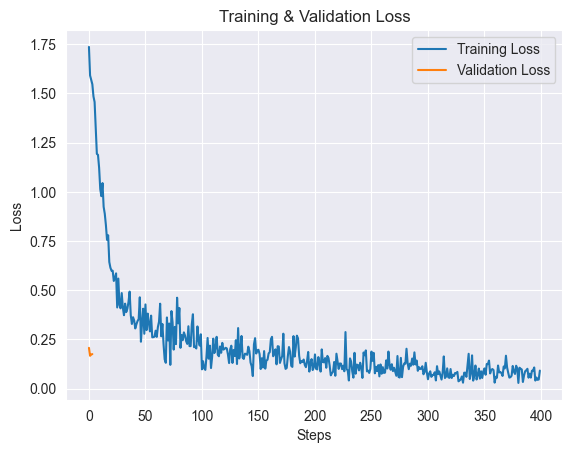

In [15]:
# Extract training and evaluation loss values from the Trainer's log history
logs = trainer.state.log_history

# Filter and collect loss values
loss_train = [x["loss"] for x in logs if "loss" in x]           # Training loss logged during steps
loss_eval = [x["eval_loss"] for x in logs if "eval_loss" in x] # Validation loss logged after each epoch

# Plot the loss curves
plt.plot(loss_train, label="Training Loss")
plt.plot(loss_eval, label="Validation Loss")
plt.xlabel("Steps")
plt.ylabel("Loss")
plt.legend()
plt.title("Training & Validation Loss")
plt.grid(True)
plt.show()


In [16]:
# Run prediction on the test set using the trained model
test_results = trainer.predict(tokenized_emotion["test"])

# Extract true labels and predicted labels
y_true = test_results.label_ids                                 # Ground truth labels
y_pred = np.argmax(test_results.predictions, axis=1)            # Predicted labels (argmax of logits)

# Print overall test accuracy
print("Test Accuracy:", accuracy_score(y_true, y_pred))


/Users/samersakor/LUH/Text_Mining/Emotion_BERT/.venv/lib/python3.9/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Test Accuracy: 0.927


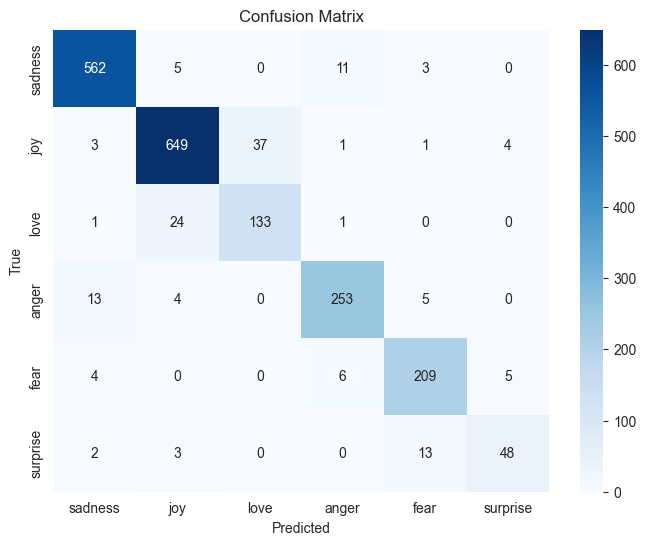

In [17]:
# Generate a confusion matrix to analyze per-class prediction performance
cm = confusion_matrix(y_true, y_pred)

# Plot the confusion matrix using seaborn heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(
    cm,
    annot=True,                          # Show counts in cells
    fmt="d",                             # Format as integers
    xticklabels=emotion_labels,          # Label x-axis with class names
    yticklabels=emotion_labels,          # Label y-axis with class names
    cmap="Blues"                         # Color scheme
)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()


In [18]:
# Generate a detailed classification report showing precision, recall, and F1-score for each emotion class.
# Also includes macro average, weighted average, and overall accuracy.
print(classification_report(y_true, y_pred, target_names=emotion_labels))


              precision    recall  f1-score   support

     sadness       0.96      0.97      0.96       581
         joy       0.95      0.93      0.94       695
        love       0.78      0.84      0.81       159
       anger       0.93      0.92      0.93       275
        fear       0.90      0.93      0.92       224
    surprise       0.84      0.73      0.78        66

    accuracy                           0.93      2000
   macro avg       0.89      0.89      0.89      2000
weighted avg       0.93      0.93      0.93      2000

